In [1]:
import nltk
import string
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.downloader import download

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from apyori import apriori
import networkx as nx 

In [26]:
df=pd.read_csv('./data/38.csv', encoding="ISO-8859-1", dtype={'CustomerID': str,'InvoiceID': str})
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850,United Kingdom


In [27]:
#######################################
# change to datatime
df['InvoiceDate']= pd.to_datetime(df['InvoiceDate'])
# Remove spaces at the beginning and at the end of the string
df["Description"]=df["Description"].str.strip()
# Clean up the non purchase invoices.
df["InvoiceNo"]=df["InvoiceNo"].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]
# Calculate total amount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalAmount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     134697
Country             0
TotalAmount         0
dtype: int64

In [ ]:
df=df.dropna(subset=['Description'],inplace=True)

In [ ]:
##########################

In [28]:
# transform the data
df_transactional=df.groupby(["InvoiceNo", "Description"])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo")
df_transactional.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# create function to encode 
def unit_encode(x):
    if(x<=0):
        return 0
    if(x>=1):
        return 1
df_transactional_encoded=df_transactional.applymap(unit_encode)
df_transactional_encoded.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [229]:
df_transactional_list=df.groupby(["InvoiceNo"])["Description"].apply(list)
df_transactional_list[1:10]

InvoiceNo
536366    [HAND WARMER UNION JACK, HAND WARMER RED POLKA...
536367    [ASSORTED COLOUR BIRD ORNAMENT, POPPY'S PLAYHO...
536368    [JAM MAKING SET WITH JARS, RED COAT RACK PARIS...
536369                           [BATH BUILDING BLOCK WORD]
536370    [ALARM CLOCK BAKELIKE PINK, ALARM CLOCK BAKELI...
536371                     [PAPER CHAIN KIT 50'S CHRISTMAS]
536372    [HAND WARMER RED POLKA DOT, HAND WARMER UNION ...
536373    [WHITE HANGING HEART T-LIGHT HOLDER, WHITE MET...
536374                         [VICTORIAN SEWING BOX LARGE]
Name: Description, dtype: object

In [41]:
from mlxtend.frequent_patterns import apriori, association_rules
# look for frequent items that has 3% support
frequent_items=apriori(df_transactional_encoded, min_support=0.03, use_colnames=True)
frequent_items.head()

c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.046337,(6 RIBBONS RUSTIC CHARM)
1,0.040175,(60 TEATIME FAIRY CAKE CASES)
2,0.047550,(ALARM CLOCK BAKELIKE GREEN)
3,0.037991,(ALARM CLOCK BAKELIKE PINK)
4,0.050995,(ALARM CLOCK BAKELIKE RED)


In [42]:
# look at the results with  lift score of >= 0.1
results = association_rules(frequent_items, metric ="lift", min_threshold = 0.1) 
#results.sort_values(["confidence", "lift"], ascending=[False, False])
results.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.050995,0.047550,0.031053,0.608944,12.806462,0.028628,2.435585
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.047550,0.050995,0.031053,0.653061,12.806462,0.028628,2.735368
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037166,0.049248,0.030713,0.826371,16.779804,0.028883,5.475760
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.049248,0.037166,0.030713,0.623645,16.779804,0.028883,2.558314
4,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.049248,0.051722,0.037263,0.756650,14.629045,0.034716,3.896768


In [44]:
# results.nlargest(10, "confidence")['antecedents'].iloc[0]
results.sort_values(["confidence"], ascending=True).iloc[0:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
8,(JUMBO BAG RED RETROSPOT),(JUMBO SHOPPER VINTAGE RED PAISLEY),0.101504,0.057011,0.032994,0.325048,5.701477,0.027207,1.397119
11,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.101504,0.057448,0.035129,0.346080,6.024253,0.029297,1.441388
6,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.101504,0.059098,0.040029,0.394359,6.673028,0.034030,1.553566
12,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.075885,0.061766,0.031101,0.409847,6.635457,0.026414,1.589813
13,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.061766,0.075885,0.031101,0.503535,6.635457,0.026414,1.861389


In [244]:
# top 10 association rules
top_ten_association_results= results.nlargest(10, "confidence")
top_ten_association_results

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037166,0.049248,0.030713,0.826371,16.779804,0.028883,5.475760
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.049248,0.051722,0.037263,0.756650,14.629045,0.034716,3.896768
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.051722,0.049248,0.037263,0.720450,14.629045,0.034716,3.401012
6,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.059098,0.101504,0.040029,0.677340,6.673028,0.034030,2.784651
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.047550,0.050995,0.031053,0.653061,12.806462,0.028628,2.735368
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.049248,0.037166,0.030713,0.623645,16.779804,0.028883,2.558314
10,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.057448,0.101504,0.035129,0.611486,6.024253,0.029297,2.312650
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.050995,0.047550,0.031053,0.608944,12.806462,0.028628,2.435585
8,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.057011,0.101504,0.032994,0.578723,5.701477,0.027207,2.132793
13,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.061766,0.075885,0.031101,0.503535,6.635457,0.026414,1.861389


In [ ]:
# df1=df.dropna(subset=['Description'])
# df1.isnull().sum()

# df_transactional_1=df1.groupby(["InvoiceNo", "Description"])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo")
# # df_transactional_1.head()

# #######################
# def unit_encode(x):
#     if(x<=0):
#         return 0
#     if(x>=1):
#         return 1
# df_transactional_encoded_1=df_transactional_1.applymap(unit_encode)
# # df_transactional_encoded_1.head()

# ##############
# from mlxtend.frequent_patterns import apriori, association_rules
# # look for frequent items that has 3% support
# frequent_items_1=apriori(df_transactional_encoded_1, min_support=0.03, use_colnames=True)
# # frequent_items_1.head()

# ###############
# # look at the results with  lift score of >= 0.1
# results_1 = association_rules(frequent_items_1, metric ="lift", min_threshold = 0.1) 
# #rules.sort_values(["confidence", "lift"], ascending=[False, False])
# # results_1.head()

# ############
# # top 10 association rules
# top_ten_association_results_1= results_1.nlargest(10, "confidence")
# top_ten_association_results_1

In [ ]:
####################################
####### Draw the association #######
####################################

In [31]:
def convert_to_network(df):
    print(df)

    #BUILD GRAPH
    G = nx.DiGraph()  # DIRECTED
    for row in df.iterrows():
        # for column in df.columns:
        lhs="_".join(row[1][0])
        rhs="_".join(row[1][1])
        conf=row[1][3]; #print(conf)
        if(lhs not in G.nodes): 
            G.add_node(lhs)
        if(rhs not in G.nodes): 
            G.add_node(rhs)

        edge=(lhs,rhs)
        if edge not in G.edges:
            G.add_edge(lhs, rhs, weight=conf)

    # print(G.nodes)
    # print(G.edges)
    return G

In [32]:
def plot_network(G):
    #SPECIFIY X-Y POSITIONS FOR PLOTTING
    pos=nx.random_layout(G)

    #GENERATE PLOT
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 10)

    #assign colors based on attributes
    weights_e 	= [G[u][v]['weight'] for u,v in G.edges()]

    #SAMPLE CMAP FOR COLORS 
    cmap=plt.cm.get_cmap('Blues')
    colors_e 	= [cmap(G[u][v]['weight']*10) for u,v in G.edges()]

    #PLOT
    nx.draw(
    G,
    edgecolors="black",
    edge_color=colors_e,
    node_size=2000,
    linewidths=2,
    font_size=8,
    font_color="black",
    font_weight="bold",
    width=weights_e,
    with_labels=True,
    pos=pos,
    ax=ax
    )
    ax.set(title='Product buy')
    plt.show()

                            antecedents                          consequents  \
0          (ALARM CLOCK BAKELIKE GREEN)           (ALARM CLOCK BAKELIKE RED)   
1            (ALARM CLOCK BAKELIKE RED)         (ALARM CLOCK BAKELIKE GREEN)   
2      (PINK REGENCY TEACUP AND SAUCER)    (GREEN REGENCY TEACUP AND SAUCER)   
3     (GREEN REGENCY TEACUP AND SAUCER)     (PINK REGENCY TEACUP AND SAUCER)   
4     (ROSES REGENCY TEACUP AND SAUCER)    (GREEN REGENCY TEACUP AND SAUCER)   
5     (GREEN REGENCY TEACUP AND SAUCER)    (ROSES REGENCY TEACUP AND SAUCER)   
6             (JUMBO BAG PINK POLKADOT)            (JUMBO BAG RED RETROSPOT)   
7             (JUMBO BAG RED RETROSPOT)            (JUMBO BAG PINK POLKADOT)   
8   (JUMBO SHOPPER VINTAGE RED PAISLEY)            (JUMBO BAG RED RETROSPOT)   
9             (JUMBO BAG RED RETROSPOT)  (JUMBO SHOPPER VINTAGE RED PAISLEY)   
10             (JUMBO STORAGE BAG SUKI)            (JUMBO BAG RED RETROSPOT)   
11            (JUMBO BAG RED RETROSPOT) 

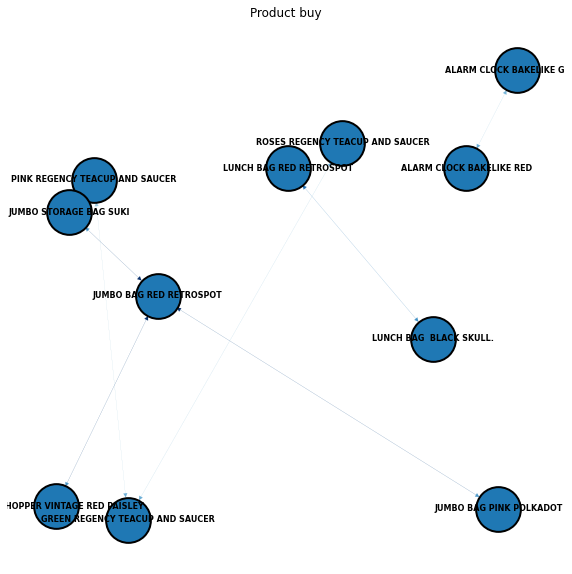

In [307]:
G=convert_to_network(results)
plot_network(G)

In [ ]:
###################################
# use less minimum support

In [34]:
from mlxtend.frequent_patterns import apriori, association_rules
# look for frequent items that has 2% support
frequent_items_2=apriori(df_transactional_encoded, min_support=0.02, use_colnames=True)
frequent_items_2.head()
# look at the results with  lift score of >= 0.1
results_2 = association_rules(frequent_items_2, metric ="lift", min_threshold = 0.1) 
results_2.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(PACK OF 72 RETROSPOT CAKE CASES),(60 TEATIME FAIRY CAKE CASES),0.064047,0.040175,0.021980,0.343182,8.542243,0.019407,1.461326
1,(60 TEATIME FAIRY CAKE CASES),(PACK OF 72 RETROSPOT CAKE CASES),0.040175,0.064047,0.021980,0.547101,8.542243,0.019407,2.066585
2,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.037991,0.047550,0.020281,0.533844,11.227070,0.018475,2.043202
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.047550,0.037991,0.020281,0.426531,11.227070,0.018475,1.677524
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.050995,0.047550,0.031053,0.608944,12.806462,0.028628,2.435585


In [48]:
results_2.sort_values("confidence", ascending=True).iloc[0:5]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
129,(WHITE HANGING HEART T-LIGHT HOLDER),(NATURAL SLATE HEART CHALKBOARD),0.109656,0.060602,0.020136,0.183628,3.030088,0.013491,1.150699
158,(JUMBO BAG RED RETROSPOT),"(JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT)",0.101504,0.024988,0.020039,0.197419,7.900583,0.017502,1.214845
68,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SKULLS),0.101504,0.034207,0.020087,0.197897,5.785322,0.016615,1.204076
40,(JUMBO BAG RED RETROSPOT),(JUMBO BAG ALPHABET),0.101504,0.043959,0.020087,0.197897,4.501823,0.015625,1.191917
74,(JUMBO BAG RED RETROSPOT),(RECYCLING BAG RETROSPOT),0.101504,0.036293,0.020136,0.198375,5.465914,0.016452,1.202191


In [36]:
results_2.nlargest(10, "confidence")

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
149,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",(GREEN REGENCY TEACUP AND SAUCER),0.029064,0.049248,0.026298,0.904841,18.373184,0.024867,9.991237
148,"(PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...",(ROSES REGENCY TEACUP AND SAUCER),0.030713,0.051722,0.026298,0.856240,16.554511,0.024709,6.596260
22,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037166,0.049248,0.030713,0.826371,16.779804,0.028883,5.475760
155,"(JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT)",(JUMBO BAG RED RETROSPOT),0.024988,0.101504,0.020039,0.801942,7.900583,0.017502,4.536523
136,(PINK REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.037166,0.051722,0.029064,0.781984,15.118853,0.027141,4.349584
26,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.049248,0.051722,0.037263,0.756650,14.629045,0.034716,3.896768
27,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.051722,0.049248,0.037263,0.720450,14.629045,0.034716,3.401012
20,(GARDENERS KNEELING PAD CUP OF TEA),(GARDENERS KNEELING PAD KEEP CALM),0.036778,0.044299,0.026492,0.720317,16.260379,0.024863,3.417082
151,(PINK REGENCY TEACUP AND SAUCER),"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",0.037166,0.037263,0.026298,0.707572,18.988353,0.024913,3.292215
150,"(GREEN REGENCY TEACUP AND SAUCER, ROSES REGENC...",(PINK REGENCY TEACUP AND SAUCER),0.037263,0.037166,0.026298,0.705729,18.988353,0.024913,3.271930


In [39]:
results_2.nlargest(10, "confidence")['antecedents'].iloc[0]

frozenset({'PINK REGENCY TEACUP AND SAUCER',
           'ROSES REGENCY TEACUP AND SAUCER'})

                                           antecedents  \
0                    (PACK OF 72 RETROSPOT CAKE CASES)   
1                        (60 TEATIME FAIRY CAKE CASES)   
2                          (ALARM CLOCK BAKELIKE PINK)   
3                         (ALARM CLOCK BAKELIKE GREEN)   
4                           (ALARM CLOCK BAKELIKE RED)   
..                                                 ...   
155  (JUMBO STORAGE BAG SUKI, JUMBO BAG PINK POLKADOT)   
156  (JUMBO BAG RED RETROSPOT, JUMBO BAG PINK POLKA...   
157                           (JUMBO STORAGE BAG SUKI)   
158                          (JUMBO BAG RED RETROSPOT)   
159                          (JUMBO BAG PINK POLKADOT)   

                                           consequents  antecedent support  \
0                        (60 TEATIME FAIRY CAKE CASES)            0.064047   
1                    (PACK OF 72 RETROSPOT CAKE CASES)            0.040175   
2                         (ALARM CLOCK BAKELIKE GREEN)            0.0

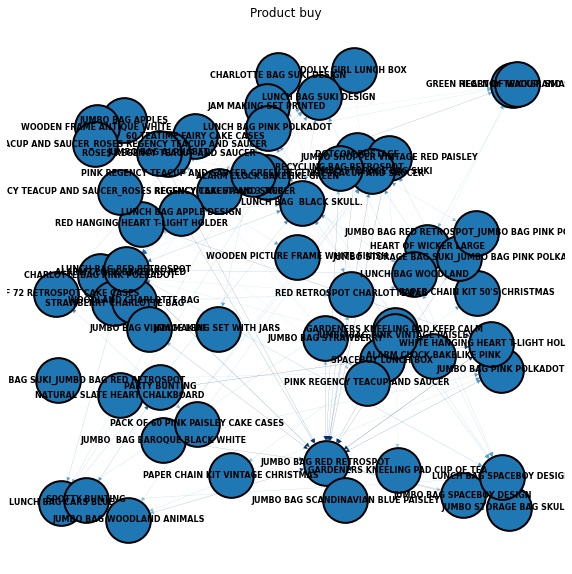

In [35]:
G2=convert_to_network(results_2)
plot_network(G2)

In [ ]:
##############################
# check for a specific country

In [40]:
df['Country'].value_counts().head()

United Kingdom    487622
Germany             9042
France              8408
EIRE                7894
Spain               2485
Name: Country, dtype: int64

In [308]:
# check for UK
df_transactional_UK=df[df['Country']=='United Kingdom'].groupby(["InvoiceNo", "Description"])["Quantity"].sum().unstack().reset_index().fillna(0).set_index("InvoiceNo")
df_transactional_UK.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [309]:
def unit_encode(x):
    if(x<=0):
        return 0
    if(x>=1):
        return 1
df_transactional_encoded_UK=df_transactional_UK.applymap(unit_encode)
df_transactional_encoded_UK.head()

Description,*Boombox Ipod Classic,*USB Office Mirror Ball,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [317]:
frequent_items_UK=apriori(df_transactional_encoded_UK, min_support=0.03, use_colnames=True)
frequent_items_UK.head()

c:\Users\84160\AppData\Local\Programs\Python\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
0,0.045800,(6 RIBBONS RUSTIC CHARM)
1,0.031123,(60 CAKE CASES VINTAGE CHRISTMAS)
2,0.040336,(60 TEATIME FAIRY CAKE CASES)
3,0.046925,(ALARM CLOCK BAKELIKE GREEN)
4,0.035140,(ALARM CLOCK BAKELIKE PINK)


In [318]:
# look at the results with  lift score of >= 0.1
results_UK = association_rules(frequent_items_UK, metric ="lift", min_threshold = 0.1) 
#results_UK.sort_values(["confidence", "lift"], ascending=[False, False])
results_UK.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.046925,0.049818,0.030159,0.642694,12.900874,0.027821,2.659296
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.049818,0.046925,0.030159,0.605376,12.900874,0.027821,2.415149
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037658,0.050032,0.030909,0.820768,16.404818,0.029024,5.300218
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050032,0.037658,0.030909,0.617773,16.404818,0.029024,2.517724
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.051264,0.050032,0.037551,0.732497,14.640537,0.034986,3.551247


In [ ]:
# results_UK.sort_values("confidence", ascending=True).iloc[0:5]

In [319]:
# top 10 association rules
top_ten_association_results_UK= results_UK.nlargest(10, "confidence")
top_ten_association_results_UK

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
2,(PINK REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.037658,0.050032,0.030909,0.820768,16.404818,0.029024,5.300218
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.050032,0.051264,0.037551,0.750535,14.640537,0.034986,3.803087
4,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.051264,0.050032,0.037551,0.732497,14.640537,0.034986,3.551247
8,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.062085,0.103814,0.042051,0.677308,6.524245,0.035605,2.777218
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.046925,0.049818,0.030159,0.642694,12.900874,0.027821,2.659296
6,(JUMBO BAG BAROQUE BLACK WHITE),(JUMBO BAG RED RETROSPOT),0.048747,0.103814,0.030534,0.626374,6.033613,0.025473,2.398615
3,(GREEN REGENCY TEACUP AND SAUCER),(PINK REGENCY TEACUP AND SAUCER),0.050032,0.037658,0.030909,0.617773,16.404818,0.029024,2.517724
12,(JUMBO STORAGE BAG SUKI),(JUMBO BAG RED RETROSPOT),0.060531,0.103814,0.037390,0.617699,5.950055,0.031106,2.344190
1,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.049818,0.046925,0.030159,0.605376,12.900874,0.027821,2.415149
10,(JUMBO SHOPPER VINTAGE RED PAISLEY),(JUMBO BAG RED RETROSPOT),0.060692,0.103814,0.035194,0.579876,5.585724,0.028893,2.133149


                            antecedents                          consequents  \
0          (ALARM CLOCK BAKELIKE GREEN)           (ALARM CLOCK BAKELIKE RED)   
1            (ALARM CLOCK BAKELIKE RED)         (ALARM CLOCK BAKELIKE GREEN)   
2      (PINK REGENCY TEACUP AND SAUCER)    (GREEN REGENCY TEACUP AND SAUCER)   
3     (GREEN REGENCY TEACUP AND SAUCER)     (PINK REGENCY TEACUP AND SAUCER)   
4     (ROSES REGENCY TEACUP AND SAUCER)    (GREEN REGENCY TEACUP AND SAUCER)   
5     (GREEN REGENCY TEACUP AND SAUCER)    (ROSES REGENCY TEACUP AND SAUCER)   
6      (JUMBO  BAG BAROQUE BLACK WHITE)            (JUMBO BAG RED RETROSPOT)   
7             (JUMBO BAG RED RETROSPOT)     (JUMBO  BAG BAROQUE BLACK WHITE)   
8             (JUMBO BAG PINK POLKADOT)            (JUMBO BAG RED RETROSPOT)   
9             (JUMBO BAG RED RETROSPOT)            (JUMBO BAG PINK POLKADOT)   
10  (JUMBO SHOPPER VINTAGE RED PAISLEY)            (JUMBO BAG RED RETROSPOT)   
11            (JUMBO BAG RED RETROSPOT) 

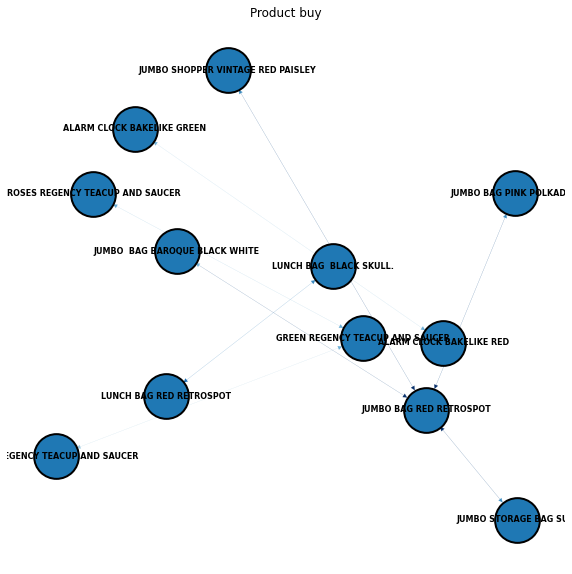

In [320]:
G=convert_to_network(results_UK)
plot_network(G)